# ARTS multi-FOV surface retrievals

In [1]:
#  d duncan, 08/02/19
#  this script builds on amsr2_test2.ipynb and adds the use of ARTS OEM to experiment
#    with retrieval of a perturbed scene. the goal here is to probe the spatial resolution
#    of geophysical parameter variations that may be possible with such a sensor, focused
#    here on AMSR2 and surface parameters (SST, wind speed)

#  note: for speed, the angular grid is the big culprit, so if using low frequencies only
#    then angfac<10 is quite justified

# this setup, in steps/words:
### - define an antenna response that is frequency dependent, gaussian, symmetric
### - define sensor position and line of sight for each scan at middle of scan
### - define an angular grid (zenith & azimuth) for each scan that encompasses npix
### - sensor angles are all 'absolute' whereas the angular grid and antenna response 
###    are all relative to the central bore sight of the scan
### - a lat/lon grid is also defined that must encompass all observation points simulated
### - the same angular grid and simulation setup is assumed/copied for all nscans, and 
###    mblock_dlos_grid allows all simulations to be run at the same time

### *** this setup outputs simulated TBs for chosen channels of AMSR2
###    with antenna patterns taken into account and decoupled from any retrieval grid, with
###    pencil beam calculations sampling the antenna pattern according to the angular grid
###    defined

In [2]:
pv = 'v1-0' # plot version (end of plots' filenames)

fsub  = np.array([0, 1, 2]) # choose which frequencies to run (runs both polarisations--v/h)
fsub = np.array([0,1,2,3,4,5])

npix     =  17   # pixels across each scan considered
nscans   =  17   # consecutive scans considered
angfac   =   3   # angular samples per degree or between pix -- should be min ~10 (but depends on freqs used)
npol     =  2    # number of polarizations considered (2=V/H both, 1=intensity only)

nrvar = 1 # number of retrieval variables, 1 will be SST only, 2 for SST+windspeed
sx_sst = 1.5   # a priori std deviation for SST
nedt   = 0.34  # at first assume constant across channels -- in reality [0.34,.43,.7,.7,.6,.7,1.2]

In [3]:

%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/ 

%matplotlib inline
#from h5py import File

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

from typhon.arts.workspace.variables import *

ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )
@arts_agenda
def geo_pos_agendaPY(ws):
    ws.geo_posEndOfPpath()
ws.Copy( ws.geo_pos_agenda, geo_pos_agendaPY)  ## new one, set by patrick in his cfile

# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])#,"liquidcloud-ELL07"])
ws.abs_lines_per_speciesSetEmpty()

ws.stokes_dim = npol # to get V and H pol set to 2
ws.iy_unit = "PlanckBT" # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [4]:
# Define lat/lon grid that observation points and angular grid lie within
lat0     = 0.0  # center of grid in lat, lon
lon0     = 0.0
nlat, nlon = 40, 40    # number of lat and lon divisions
latwid, lonwid = 2, 2  # just asssume square for now, widths double these
res = 2*latwid/nlat # assume equal in lat/lon for now
print('grid resolution is ',res)
 
#lat_grid = lat0 + np.linspace(-latwid,latwid,nlat) # [-3:0.25:3]
lat_grid = lat0 + np.arange(-latwid,latwid+res,res)
lon_grid = lon0 + np.arange(-lonwid,lonwid+res,res)
# keep these (non-ws vars) for sake of plotting at the end!
 
ws.lat_grid = lat_grid[0:nlat]+np.diff(lat_grid)*.5 # to avoid mismatch between ARTS and pcolormesh
ws.lon_grid = lon_grid[0:nlon]+np.diff(lon_grid)*.5 #  i.e. getting lat/lon midpoints of boxes
print(lon_grid)
print(ws.lon_grid.value)

grid resolution is  0.1
[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00]
[-1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35 -1.25 -1.15 -1.05 -0.95 -0.85
 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35  1.45  1.55
  1.65  1.75  1.85  1.95]


In [5]:
print('corners of lat_grid: ',lat_grid)
print('midpoints of lat_grid (ARTS ws grid): ',lat_grid[0:nlat]+np.diff(lat_grid)*.5)

corners of lat_grid:  [-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00]
midpoints of lat_grid (ARTS ws grid):  [-1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35 -1.25 -1.15 -1.05 -0.95 -0.85
 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35  1.45  1.55
  1.65  1.75  1.85  1.95]


In [6]:
# set up atmosphere and surface variables:
ws.atmosphere_dim = 3  # 3D atmosphere
p = np.array([1015.,950.,800.])*100.0 #keep it simple, otherwise slower fwd model -- IGNORES LOTS OF WV!!!
#p = np.array([1015.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] 
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet3D()
ws.AtmFieldsCalcExpand1D()  # set to given p_grid or z_grid

#ws.vmr_field.value[:,:,:,:] *= 0.00 # try decreasing water vapor by X

# if using coarse atmosphere but wanting accurate ray tracing:
ws.ppath_lmax = 250.0  # set maximum distance between points when computing absorption along path

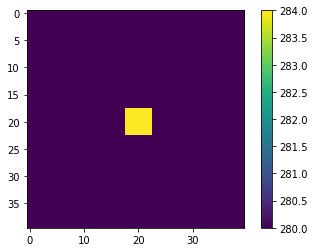

In [7]:
# Surface properties -- define ocean surface for simulations

nala, nalo = np.size(ws.lat_grid.value), np.size(ws.lon_grid.value) # size of ARTS lat/lon grid
s_names = ["Water skin temperature","Wind speed","Wind direction","Salinity"]
s_data = np.zeros([len(s_names), nala, nalo])

tmean                   = 280.0 # sst mean
wsp                     = 2.3   # 10m wind speed
s_data[0,:,:] = tmean
#s_data[0,int(nlat/2)-1:int(nlat/2)+2,int(nlon/2)-1:int(nlon/2)+2] += 6
#s_data[0,:,::8] += 0.9  ## czechers
s_data[0,int(nlat/2)-2:int(nlat/2)+3,int(nlon/2)-2:int(nlon/2)+3] += 4.0
#s_data[0,1::4,::2] += 2.9  ## czechers
#s_data[0,::2,1::2] += 1.9
#s_data[0,:,:] += np.tile(np.arange(0,nala),[nalo,1])
#s_data[0,18:21,18:21] = tmean +6.5 # some preturbation
#s_data[0,int(nlat/2),int(nlon/2)] = tmean +9.5 # some preturbation
s_data[1,:,:] = wsp
#s_data[1,:,:] += np.tile(np.arange(0,nalo),[nala,1]).transpose() 
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value

# write these to ARTS variables 
ws.Copy(ws.surface_props_names, s_names)
ws.Copy(ws.surface_props_data, s_data)
ws.MatrixSetConstant(ws.z_surface, nala, nalo, 0.0) # explicitly set the surface to 0m altitude

plt.imshow(s_data[0,:,:]) # quick look for SST
plt.colorbar()
plt.show()
#plt.imshow(s_data[1,:,:])
#plt.colorbar()
#plt.show()

In [8]:
# Set and calculate some basic variables for antenna and scanning
### all will be replaced or superseded when moving to using L1R data as input
 
zsat   = 699.7e3      # Satellite altitde [m] -- can read this in later
vsat   = 6.76e3       # Satellite velocity [m/s]
dt     = 2.6e-3       # Integration time [s] -- 2.6ms for low freqs, 1.3ms for 89GHz
rpm    = 40           # Rotations per minute -- same for AMSR-E and AMSR2
 
# find nautical mile constant?  1852m = 1nmi
m2deg  = 1/(60*1852) #constants('NAUTICAL_MILE'))    # Conversion from m to latitude
dang   = dt * 360 * rpm / 60                  # Angular distance between samples
dlat   = m2deg * vsat * 60 / rpm              # Latitude distance between scans
print(dang,dlat)

0.624 0.09125269978401726


# Define antenna pattern

In [9]:

width  = 1.8           # Max half-width of antenna (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth for now)
# for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994.
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] 
#adata = [[ 6.600e9 ,  1.8],   # AMSR2 center frequency and beamwidth (deg)
#         [ 7.300e9 ,  1.8],   # assumed the same for V/H polarizations
#         [ 11.00e9 ,  1.2]] #,  ## changed to be greater than f_grid defined in metmm

adata = np.array(adata, order="C").transpose()[:,fsub] # choose selected frequencies (set above)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)

csub = np.sort(np.append(fsub*2,fsub*2+1))
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H',
                   '23V','23H','36V','36H','89V','89H'])[csub] # just chosen freqs
print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
if npol==2: gsp="1" 
else: gsp="0"
gf4.grids = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

#blah = [4589.014643600229,
#4589.014643600229,
#2039.5620638223247]
for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )
    #gf4.data[0,i,:,:] = np.exp( - (np.tile(x2,[nx,1]) + np.tile(x2,[nx,1]).transpose())/ si**2 ) # equivalent
    #print(np.sum(gf4.data[0,i,:,:])/blah[i])


# frequency grid of simulation is defined according to sensor setup above (may change with use of metmm)
f_grid = np.copy(gf4.grids[1])  # array with each frequency (not channel)

ws.f_grid.value = f_grid
print('f_grid: ',ws.f_grid.value)
 

angular resolution of response grid [deg]:  0.01
['6V' '6H' '7V' '7H' '10V' '10H' '18V' '18H' '23V' '23H' '36V' '36H']
size of antenna_reponse grid:  (1, 6, 361, 361)
f_grid:  [6.925e+09 7.300e+09 1.065e+10 1.870e+10 2.380e+10 3.650e+10]


In [10]:

#plt.figure(figsize=[9,9])
#plt.pcolormesh(gf4.data[0,0,:,:])
#plt.colorbar()
#plt.show()

# Define bore sights for one scan, angular grid for fwd model

In [11]:
# Determine bore-sight angles to use for one scan 
 
# psteps defines the pixels across one scan
psteps   = np.arange(-(npix-1)/2, (npix-1)/2 +1, 1)  #  if npix is odd then middle boresight is in the middle
# ssteps defines position of spacecraft for each scan, evenly distributed around a middle scan
ssteps   = np.arange(-(nscans-1)/2, (nscans-1)/2 +1, 1) 
#print('pixel steps',psteps)

#  center line of sight... defined as AMSR2 EIA and 0 azimuth angle
los0    = [ 180-47.5, 0 ]  # 47.5 is off-nadir angle of AMSR2

# bsights defines the bore sight zenith and azimuth angles across the scan 
##-- just for one scan, assumed to be same for each scan?
bsights = np.array([ np.repeat(los0[0],npix), los0[1]+dang*psteps ]).transpose()  # size: [npix,2]
print('bsights:',(bsights[:,1]))

bsights: [-4.992 -4.368 -3.744 -3.12  -2.496 -1.872 -1.248 -0.624  0.     0.624
  1.248  1.872  2.496  3.12   3.744  4.368  4.992]


In [12]:
# Define angular grid for pencilbeam calculations

# can use 'dang' or not, but benefit of using it is having RT calc at each boresight
#  in azimuth direction. if using 'dang' for zenith too then it's an evenly spaced angular grid.

n = np.floor( width * angfac )  # angular width * angular samples per deg
print(n)
za_grid = np.array( los0[0] +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
#n = np.floor( angfac * width / dang )  # number per degree * angular width / distance between boresights
#za_grid = np.array( los0[0] + (dang/angfac) * np.arange(-n,n+1))  # zenith angle grid
print('zenith grid: ',za_grid) 

en = np.floor( angfac * ( bsights[-1,1] + width ) / dang ) # azimuth of boresight at edge +width
print(en)
aa_grid = np.array( los0[1] + (dang/angfac) * np.arange(-en,en+1))  # azimuth angle grid
#en = np.floor((bsights[-1,1]+width)*angfac) ## yields az from boresight at edge plus 'width' (could prob do width/2)
#aa_grid = np.array( los0[1] + np.arange(-en,en+1/angfac)/angfac)  # azimuth angle grid
print('azimuth grid: ',aa_grid) 


5.0
zenith grid:  [130.83333333 131.16666667 131.5        131.83333333 132.16666667
 132.5        132.83333333 133.16666667 133.5        133.83333333
 134.16666667]
32.0
azimuth grid:  [-6.656 -6.448 -6.24  -6.032 -5.824 -5.616 -5.408 -5.2   -4.992 -4.784
 -4.576 -4.368 -4.16  -3.952 -3.744 -3.536 -3.328 -3.12  -2.912 -2.704
 -2.496 -2.288 -2.08  -1.872 -1.664 -1.456 -1.248 -1.04  -0.832 -0.624
 -0.416 -0.208  0.     0.208  0.416  0.624  0.832  1.04   1.248  1.456
  1.664  1.872  2.08   2.288  2.496  2.704  2.912  3.12   3.328  3.536
  3.744  3.952  4.16   4.368  4.576  4.784  4.992  5.2    5.408  5.616
  5.824  6.032  6.24   6.448  6.656]


In [13]:
# Set sensor_pos, sensor_los

ws.sensor_los = np.tile(los0, [nscans,1])  # sensor line of sight for each scan

shift   = 7.5    # Latitude shift to centre calculations around lat0

#### sensor_pos should be columns of altitude, SClat, SClon  ###  
####   so take all this from L1R files and transform X/Y/Z to lat/lon
# currently one alt/sclat/sclon for each scan (i.e. each of nscans)
ws.sensor_pos = np.hstack([np.repeat(zsat, nscans).reshape(nscans,1),
                          np.array(lat0 - shift + dlat * ssteps).reshape(nscans,1), 
                          np.repeat(lon0, nscans).reshape(nscans,1)])

print(ws.sensor_pos.value)
#print(np.transpose(ws.sensor_pos.value))
print(np.shape(ws.sensor_pos.value))


[[ 6.9970000e+05 -8.2300216e+00  0.0000000e+00]
 [ 6.9970000e+05 -8.1387689e+00  0.0000000e+00]
 [ 6.9970000e+05 -8.0475162e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.9562635e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.8650108e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.7737581e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.6825054e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.5912527e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.5000000e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.4087473e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.3174946e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.2262419e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.1349892e+00  0.0000000e+00]
 [ 6.9970000e+05 -7.0437365e+00  0.0000000e+00]
 [ 6.9970000e+05 -6.9524838e+00  0.0000000e+00]
 [ 6.9970000e+05 -6.8612311e+00  0.0000000e+00]
 [ 6.9970000e+05 -6.7699784e+00  0.0000000e+00]]
(17, 3)


In [14]:
# other controlfile things done in common.arts
ws.jacobianOff()
ws.cloudboxOff()

# set the surface agenda for ARTS

In [15]:
# define surface agenda:
varnam = ["Optical depth"]
ws.Copy(ws.iy_aux_vars, varnam)
ws.VectorCreate( "transmittance" )
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.0  #  FOR TESTING ONLY!!!!!
@arts_agenda
def iy_surface_agendaPY(ws):
    ws.specular_losCalc()
    # if wanting to test transmittance values, comment out next 3 calls and set outside agenda
    # if ppathCalc is called and uses assumed inputs, problems! so specify all!
    ws.ppathCalc(ws.ppath_agenda, ws.ppath_lmax, 
       ws.ppath_lraytrace, ws.atmgeom_checked, ws.t_field, ws.z_field, 
       ws.vmr_field, ws.f_grid, ws.cloudbox_on, ws.cloudbox_checked, 
       ws.ppath_inside_cloudbox_do, ws.rtp_pos, ws.specular_los, ws.rte_pos2 )
    ws.iyEmissionStandard()
    ws.transmittanceFromIy_aux(transmittance=ws.transmittance)
    ws.SurfaceFastem( transmittance = ws.transmittance, fastem_version=6 ) 
    ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# Perform checks and set up mblock grid

In [16]:
# perform some checks:
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()

In [17]:
# create vector mblock_reference_los and matrix mblock_target_los (to be used by DiffZaAa)
mblock_reference_los = np.array(los0)
print(mblock_reference_los)

# want to have all individual angle pairs distinct... so repeat one serially and one n times
mblock_target_los = np.array(np.transpose( np.stack( [ np.repeat(za_grid, aa_grid.size) , 
                                           np.tile(  aa_grid, za_grid.size) ]) ) , order = "C")
## need to specify 'C' order or else stride is wrong and array values are read wrong by ARTS

print(mblock_target_los.shape)


ws.DiffZaAa(ws.mblock_dlos_grid, mblock_reference_los, mblock_target_los)

print(np.shape(ws.mblock_dlos_grid.value))
print(np.diff(ws.mblock_dlos_grid.value[0:10,1]))
print(info(ws.mblock_dlos_grid.value[:,0]),info(ws.mblock_dlos_grid.value[:,1]))

[132.5   0. ]
(715, 2)
(715, 2)
[0.15695925 0.1569893  0.1570184  0.15704655 0.15707374 0.15709998
 0.15712526 0.15714957 0.15717293]
['-1.67E+0', '1.85E+0', '6.61E-2', '1.05E+0'] ['-5.03E+0', '5.03E+0', '0.00E+2', '2.88E+0']


In [18]:
### Calculate the sensor response function from the antenna response
ws.VectorCreate("antenna_reference_los")
ws.MatrixCreate("antenna_target_los")
ws.antenna_reference_los = np.array(los0)
ws.antenna_target_los = np.array(bsights, order="C")
ws.DiffZaAa(ws.antenna_dlos, ws.antenna_reference_los, ws.antenna_target_los)

# define sensor... done above, but apply gf4 typhon/arts object to antenna_response:
ws.sensor_norm = 1
ws.antenna_dim = 2
ws.antenna_response = gf4 

ws.sensor_responseInit()

##### don't know why this call (should be within metmm?) has to be done outside...
## flipping from I/Q to V/H here... 
ws.instrument_pol = [5,6] # indices for V,H (1,2 are I,Q)

ws.sensor_responsePolarisation()
ws.sensor_responseAntenna()
ws.sensor_checkedCalc()


# should this get called? not yet -- will give bsights from designated positions, draw a line 
#ws.sensor_losGeometricFromSensorPosToOtherPositions(ws.target_pos=np.array([]))

# Initiate the retrieval setup

In [19]:
# first, set up the retrieval grid, which is independent from fwd model and can be
#  independent from the background (lat/lon) grid

ut = 0.4 # radially out from center
r_lims = [lat0-ut, lat0+ut, lon0-ut, lon0+ut] # lat limits, lon limits  (at first just box in middle of overall box)
r_res  = res*2.0 # setting to multiple of lat/lon grid resolution for now--won't be same points as lat/lon grid 
print('retrieval grid resolution: ', r_res)
r_lon  = lon0 + np.arange(r_lims[2], r_lims[3]+r_res, r_res)
r_lat  = lat0 + np.arange(r_lims[0], r_lims[1]+r_res, r_res)

print('retrieval lon grid: ', r_lon)
print('retrieval lat grid: ', r_lat)
print(r_lon.size,r_lat.size)
#print(np.shape(initial_tb))

# create grids of retrieval lats/lons for calculations of distance and plotting below
rx, ry = np.meshgrid(r_lon, r_lat)


retrieval grid resolution:  0.2
retrieval lon grid:  [-0.4 -0.2  0.   0.2  0.4]
retrieval lat grid:  [-0.4 -0.2  0.   0.2  0.4]
5 5


(3468, 3468)
['0.00E+2', '1.13E+0', '5.10E-1', '2.46E-1', (25, 25)]
['1.04E-1', '1.00E+0', '4.06E-1', '2.01E-1', (25, 25)]


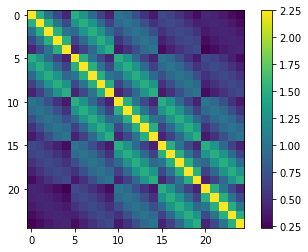

In [20]:
# set the a priori state and an initial 'measurement' vector by running yCalc first

# set Xa (formally set below)
xa = np.zeros([nrvar, r_lat.size, r_lon.size]) # a priori matrix, should be similar to s_data
xa[0,:,:] = tmean #+ 0.07  # set constant, or maybe some perturbation
#s_data[0,:,:]  # or set to copy(ws.surface_props_data[0,:,:])
#xa[1,:,:] = s_data[1,:,:]  # if adding wind speed

# then observation errors (first just sensor noise)
se_cov = np.diag(np.tile(nedt**2, npix*nscans*nf*2))
print(se_cov.shape)

# define decorrelation length for a priori correlations, use distance-dependent correlations in sx_cov
deco = 0.5     # in degrees for now
# if doing more than just sst, can calculate separately with another decorr length then use covmat_sxAddBlock
from scipy.spatial.distance import pdist      # calculate pair-wise distances (euclidean)
from scipy.spatial.distance import squareform # convert from reduced matrix to square
dists = squareform( pdist( np.array([ry.flatten(), rx.flatten()]).transpose() ))
corrs = np.exp(-dists/deco)

print(shinfo(dists))
print(shinfo(corrs))

# then a priori state errors
sx_cov = np.diag(np.tile(sx_sst**2, r_lon.size*r_lat.size)) #creates diagonal matrix with sigma=sx_sst for all
for n in range(sx_cov[0,:].size):
    sx_cov[n,:] = sx_cov[n,n] * corrs[n,:]

plt.imshow(sx_cov)
plt.colorbar()
plt.show()

In [21]:
ws.retrievalDefInit()  # initialize jacobian quantities, then add variables

#sx_cov = np.zeros([r_lon.size, r_lat.size], order="C").flatten()  # make into 1d for ARTS
#sx_cov = np.zeros([nrvar, r_lon.size, r_lat.size]).flatten()  # make into 1d for ARTS
#sx_cov = np.diag(nrvar*r_lon.size*r_lat.size) # CHANGE TO MATCH SIZE OF Xa!!

# kernel used to die here because of atm dimension check in add_block (or something)
ws.retrievalAddSurfaceQuantity( g1=r_lat, g2=r_lon, quantity=s_names[0])
ws.covmat_sxSet(sx_cov)
#ws.covmat_sxAddBlock(block = sx_cov ) #[:1, :1])
#  duplicate for other retrieved surface variables


ws.Copy(ws.xa, xa.flatten())  # copy python xa to arts xa
# print Xa to terminal:
#ws.Print(ws.xa, 0) # Print Xa

ws.covmat_seSet(se_cov)

ws.retrievalDefClose()



In [22]:
# after performing all the checks, run yCalc:

ws.yCalc()  # calculate synthetic observation vector
#print(ws.y.value)
initial_tb = np.copy(ws.y.value)  
print(np.shape(initial_tb))


(3468,)


In [23]:
# define the iteration agenda for ARTS

@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    ws.x2artsAtmAndSurf()  # map x to ARTS's variables
    
    ws.yCalc() 

    ws.Copy(ws.y_baseline, np.zeros([initial_tb.size])) # kinda silly but necessary?
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term (need to create ws.yf)
    
    ws.jacobianAdjustAndTransform()
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions

ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

In [24]:
# before calling OEM, modify (synthetic) observation vector by adding noise and/or bias offsets:

# add random gaussian noise to y -- mean, std, # of random samples
initial_tb[:] += np.random.normal(0, nedt, initial_tb.size)   # if applying chan-specific noise change this!
#initial_tb[:] += np.random.normal(-0.9, nedt*0, initial_tb.size)  # noise + bias!
ws.Copy(ws.y, initial_tb)  # copy to the ARTS y vector prior to running OEM


print('last gasp')

last gasp


In [25]:
# Call OEM:
ws.OEM(method="gn", #lm","gn"
    max_iter=14,
    display_progress=1,
    max_start_cost=1e5,
    lm_ga_settings=np.array([10.0,2.0,3.0,10000000000.0,1.0,1.0])) # only applicable for method='lm'

print(ws.oem_errors.value)  # check for errors -- empty set [] if none

ARTS[94201282229536]: 
ARTS[94201282229536]:                                 MAP Computation                                
ARTS[94201282229536]: Formulation: Standard
ARTS[94201282229536]: Method:      Gauss-Newton
ARTS[94201282229536]: 
ARTS[94201282229536]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.               
ARTS[94201282229536]: --------------------------------------------------------------------------------
ARTS[94201282229536]:     0         1.7408              0         1.7408               
ARTS[94201282229536]:     1        1.09481     0.00666915        1.08814        85.6015
ARTS[94201282229536]:     2        1.06386      0.0100143        1.05384        4.22209
ARTS[94201282229536]:     3        1.06217      0.0110109        1.05116       0.249783
ARTS[94201282229536]:     4         1.0621      0.0112936        1.05081      0.0161217
ARTS[94201282229536]:     5         1.0621      0.0113731        1.05073     0.00111599
ARTS[94201282229536]: ----

In [26]:
# yf is y_fit whereas y itself is the measurement vector here, so obs-sim is y-yf:
ydif = np.copy( ws.y.value - ws.yf.value )
ysim = np.copy( ws.yf.value)

if nrvar==1:
    xretr = np.copy( ws.x.value ).reshape(r_lat.size,r_lon.size)
else:
    print('modify to get right dimensionality in x array')

xdif = xretr - xa[0,:,:]
print(shinfo(xdif))

geo = np.copy(ws.y_geo.value) #columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
print(np.shape(ws.y.value))
# y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  

# vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
## with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!

#print(info(geo[:,1]))
#print(info(geo[:,2]))

# can compare [:,3] (az) to EIA from L1R (later), just 180-az to get EIA

['-4.09E-1', '5.25E+0', '1.04E+0', '1.68E+0', (5, 5)]
(3468,)


12 17 17
(17, 17, 12)


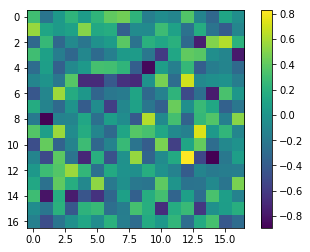

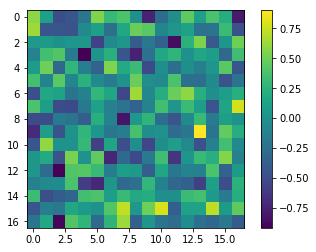

In [27]:
# convert vectors back to scan/pixel matrices:
sim_tb = np.zeros([nscans,npix,nf*2])
dif_tb = np.zeros([nscans,npix,nf*2]) 
arts_pos = np.zeros([nscans,npix,4]) 
print(nf*2,npix,nscans)

for c in range(nf*2):
    sim_tb[:,:,c] = ysim[c::nf*2].reshape(nscans,npix)
    dif_tb[:,:,c] = ydif[c::nf*2].reshape(nscans,npix)
    for bb in range(4):
        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix) 
        ## arts obs points -- can differ slightly from prescribed, are wherever max response is registered
        
    
print(np.shape(dif_tb))
#print(chan_tb[:,2,0])
plt.imshow(dif_tb[:,:,0]) # 6V obs-sim
plt.colorbar()
plt.show()
plt.imshow(dif_tb[:,:,-1]) # 10H obs-sim
plt.colorbar()
plt.show()


In [28]:
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89

# convert (roughly!) to deg near equator... okay as first approximation for plotting:
widths *= 360.0/40075.
heights*= 360.0/40075. # deg/circumference

### if wanting to get more exact with widths/heights of FOVs, can back out lat/lon differences
###  for edge of FOVs using positions with this package:
#from astropy import coordinates
#from astropy.coordinates import EarthLocation
#ploc = EarthLocation.from_geodetic(arts_pos[0,0,1],arts_pos[0,0,0], 0.0,ellipsoid='WGS84')
#ploc.
print('VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!')
print(np.diff(arts_pos[0,:,1]))
print(np.diff(arts_pos[:,0,0]))

VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!
[0.08012467 0.08018987 0.08024577 0.08029236 0.08032964 0.08035761
 0.08037625 0.08038558 0.08038558 0.08037625 0.08035761 0.08032964
 0.08029236 0.08024577 0.08018987 0.08012467]
[0.09124697 0.09124697 0.09124697 0.09124697 0.09124697 0.09124697
 0.09124697 0.09124697 0.09124697 0.09124697 0.09124697 0.09124697
 0.09124697 0.09124697 0.09124697 0.09124697]


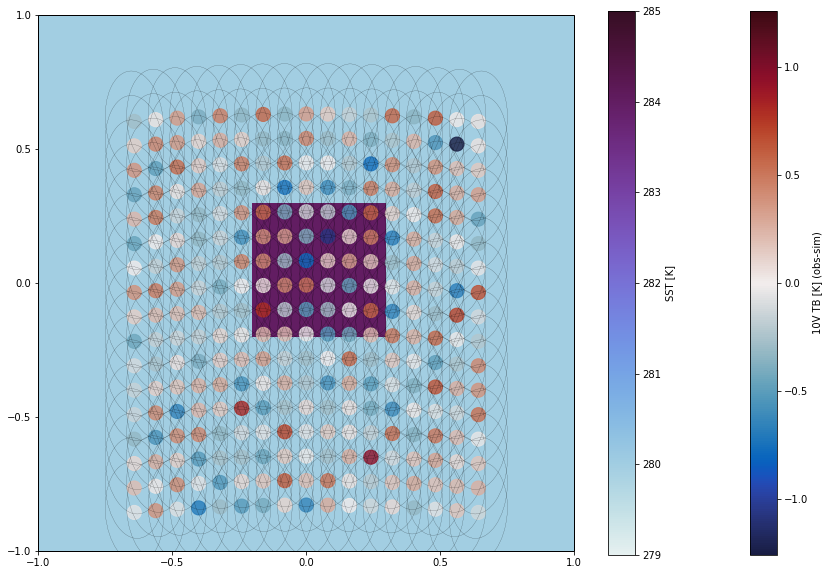

In [29]:
# plotting representative ellipses:
from matplotlib.patches import Ellipse
from cartopy import crs as ccrs
from cmocean import cm as cmo

# provide x,y coords, width, height, angle of ellipse

k=4 #nf*2-2

ells = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[int(k/2)], height=heights[int(k/2)], 
                angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False) 
        for i in range(nscans) for j in range(npix)]# for k in [0]] #range(nf*2)]

projj = ccrs.PlateCarree()
inn =  1.0#.7 #-0.3

fig = plt.figure(figsize=[15,10])
ax = plt.subplot(111, projection=projj )

#reg = [np.min(arts_pos[:,:,0])+inn, np.max(arts_pos[:,:,0])-inn,
#       np.min(arts_pos[:,:,1])+inn, np.max(arts_pos[:,:,1])-inn]
reg = [np.min(lat_grid)+inn, np.max(lat_grid)-inn,
       np.min(lon_grid)+inn, np.max(lon_grid)-inn]
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])
nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

thenorm1=plt.Normalize(vmin = np.min(s_data[0,:,:])-1, vmax = np.max(s_data[0,:,:])+1)
ceem1=cmo.dense
bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
             transform=projj, cmap=ceem1)

for e in ells[:]: 
    ax.add_artist(e)
    
vmin, vmax = -np.max(np.abs(dif_tb[:,:,k])), np.max(np.abs(dif_tb[:,:,k]))
thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
ceem = cmo.balance #thermal
ax.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=200.0, c=dif_tb[:,:,k], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_label(ch_str[k]+' TB [K] (obs-sim)')
sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax)
cb1.set_label('SST [K]')

plt.savefig('img/retr-y_syn__'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=350)
plt.show()




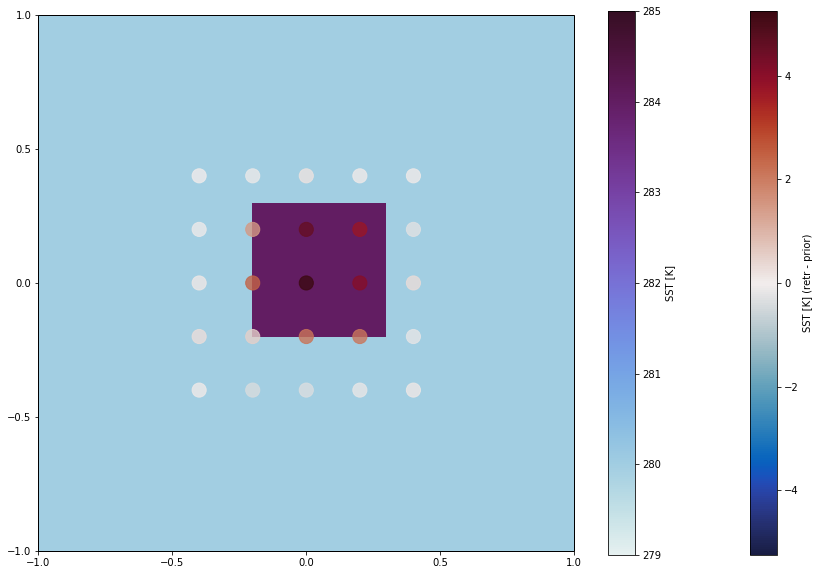

In [30]:

# and for the state vector, retrieved vs. a priori laid over background (truth):
fig2 = plt.figure(figsize=[15,10])
ax2 = plt.subplot(111, projection=projj )

ax2.set_xlim(left=reg[2], right=reg[3])
ax2.set_ylim(bottom=reg[0], top=reg[1])
ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )

bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
             transform=projj, cmap=ceem1)

#for e in ells[:]: 
#    ax2.add_artist(e)
    
vmin, vmax = -np.max(np.abs(xdif[:,:])), np.max(np.abs(xdif[:,:]))
thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
ceem = cmo.balance #thermal
# rx,ry defined earlier via meshgrid
ax2.scatter( rx, ry, s=200.0, c=xdif[:,:], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax2)
cb.set_label('SST [K] (retr - prior)')
sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax2)
cb1.set_label('SST [K]')

plt.savefig('img/retr-x_syn__'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=350)
plt.show()

In [31]:
for c in range(nf*2):
    print(info(dif_tb[:,:,c]))

['-8.92E-1', '8.25E-1', '-3.85E-2', '3.21E-1']
['-8.71E-1', '1.04E+0', '-2.99E-2', '3.39E-1']
['-1.05E+0', '9.93E-1', '2.43E-2', '3.32E-1']
['-1.08E+0', '9.32E-1', '2.30E-2', '3.41E-1']
['-1.26E+0', '9.37E-1', '9.14E-3', '3.61E-1']
['-1.01E+0', '1.11E+0', '9.64E-3', '3.54E-1']
['-1.45E+0', '1.03E+0', '9.19E-3', '3.58E-1']
['-9.32E-1', '1.08E+0', '1.67E-2', '3.22E-1']
['-9.69E-1', '1.02E+0', '3.20E-2', '3.49E-1']
['-1.21E+0', '9.84E-1', '-3.97E-3', '3.62E-1']
['-9.82E-1', '1.20E+0', '1.88E-2', '3.81E-1']
['-9.17E-1', '9.01E-1', '-1.52E-2', '3.49E-1']


In [32]:
# to run fastem alone for testing, outputting emissivities and expected TBs with no atmosphere:
#ws.MatrixCreate("emissivity")
#ws.MatrixCreate("reflectivity")
#ws.reflectivity = np.zeros([f_grid.size,4])
#ws.emissivity   = np.zeros([f_grid.size,4])
##ws.surface_skin_t = tmean #s_data[0,:,:]
##ws.transmittance
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.7
#yep = 34
#emii = np.zeros([yep,nf,2])
#tbout= np.zeros([yep,nf,2])
#tmean=270.0
#for y in range(yep):
#    ws.surface_skin_t = tmean+float(y) #s_data[0,:,:]
#    ws.FastemStandAlone(surface_skin_t= tmean+y, f_grid=ws.f_grid,
#                        emissivity=ws.emissivity, reflectivity=ws.reflectivity,
#                        za=125.0, wind_speed=wsp, rel_aa=0.0, transmittance=ws.transmittance.value)
#    emii[y,:,:] = ws.emissivity.value[:,0:2]
#    tbout[y,:,:]= ws.emissivity.value[:,0:2]*tmean+y

In [33]:
#### soooo, emissivity varies quite little with temperature for 6V (0.557->.553->.56),
#     declines slightly at 18 (.64->.58), then bigtime at 89 (.84->.74)
##print(ws.emissivity.value)
#print(emii[:,0,0]) # 6
##print(emii[:,3,0]) # 18
##print(emii[:,5,0]) # 36
#print(emii[:,-1,0]) # 89
#
#print(tbout[:,1,0])
##print(tbout[:,2,0])
#print(tbout[:,-1,0])